## This notebook is a demo for

1. Testing the convergence between the product-of-feature-matrix kernel (POFM) to the ground truth diffusion kernel.

In [1]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns


In [2]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [3]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, feature_matrix_kernel, generate_noisy_samples
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

In [4]:
# Parameters
num_nodes = 10
graph_type = 'random' # 'line', 'random'
np.random.seed(0)

In [25]:
if graph_type == 'line':
    adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)  # Circular adjacency matrix
elif graph_type == 'random':
    probability = 0.1  # Probability of edge creation
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)  # Ensure the graph is undirected
    adjacency_matrix = nx.to_numpy_array(G)  # Convert to adjacency matrix

In [26]:
ground_truth = diffusion_kernel(adj_matrix=adjacency_matrix, beta=2.0)

In [27]:
pof_matrix = feature_matrix_kernel(adj_matrix=adjacency_matrix,
                                   max_expansion=10, kernel_type='diffusion',
                                   kernel_hyperparameters={'beta': 2.0})

In [29]:
# Plotting function
def plot_heatmaps(beta_sample, max_expansion_sample):
    ground_truth = diffusion_kernel(adjacency_matrix, beta_sample)
    pof_matrix = feature_matrix_kernel(
        adj_matrix=adjacency_matrix,
        max_expansion=max_expansion_sample,
        kernel_type='diffusion',
        kernel_hyperparameters={'beta': beta_sample}
    )
    
    # Create the plots
    plt.figure(figsize=(12, 6))
    
    # Heatmap for Ground Truth
    plt.subplot(1, 2, 1)
    sns.heatmap(ground_truth, annot=True, cmap='viridis', cbar=True)
    plt.title(f"Ground Truth (Beta={beta_sample})")
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    
    # Heatmap for Product of Feature Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(pof_matrix, annot=True, cmap='viridis', cbar=True)
    plt.title(f"POF Matrix (Max Expansion={max_expansion_sample})")
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    
    plt.tight_layout()
    plt.show()

# Interactive widgets
beta_slider = widgets.FloatSlider(value=3.0, min=0.1, max=10.0, step=0.1, description='Beta:')
max_expansion_slider = widgets.IntSlider(value=10, min=1, max=20, step=1, description='Max Expansion:')
ui = widgets.VBox([beta_slider, max_expansion_slider])
out = widgets.interactive_output(plot_heatmaps, {
    'beta_sample': beta_slider,
    'max_expansion_sample': max_expansion_slider
})
display(ui, out)

Output()

Processing graph sizes: 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


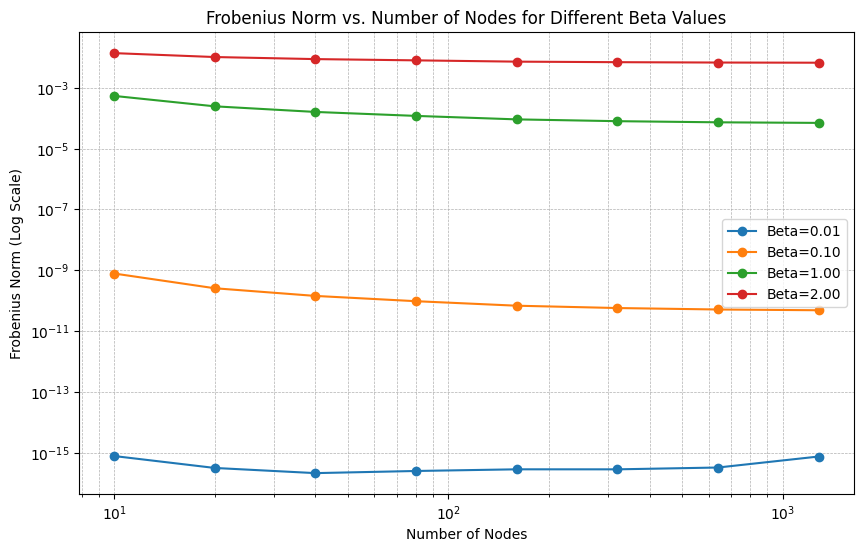

In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to generate a random graph adjacency matrix
def generate_random_graph(num_nodes, probability=0.1):
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)
    return nx.to_numpy_array(G)

# Function to plot Frobenius norm vs number of nodes
def plot_frobenius_vs_graph_size(graph_sizes, p_halt, beta_values, num_walks_per_node=1000, edge_probability=0.1):
    fro_results = {beta: [] for beta in beta_values}  # Store Frobenius norms

    for num_nodes in tqdm(graph_sizes, desc="Processing graph sizes"):
        adjacency_matrix = generate_random_graph(num_nodes, edge_probability)

        # Precompute ground truth diffusion kernels
        ground_truths = {
            beta: diffusion_kernel(adjacency_matrix, beta)
            for beta in beta_values
        }

        for beta in tqdm(beta_values, desc=f"Processing beta values for {num_nodes} nodes", leave=False):
            # Approximate diffusion kernel
            approx_cov = feature_matrix_kernel(
                adjacency_matrix,
                max_expansion=5,
                kernel_type='diffusion',
                kernel_hyperparameters={'beta': beta}
            )

            # Compute Frobenius norm
            fro_val = compute_fro(ground_truths[beta], approx_cov)
            fro_results[beta].append(fro_val)

    # Plot the results
    plt.figure(figsize=(10, 6))
    for beta, fro_values in fro_results.items():
        plt.plot(graph_sizes, fro_values, marker='o', label=f"Beta={beta:.2f}")

    plt.title("Frobenius Norm vs. Number of Nodes for Different Beta Values")
    plt.xlabel("Number of Nodes")
    plt.xscale("log")  # Optional: log scale for easier visualization
    plt.ylabel("Frobenius Norm (Log Scale)")
    plt.yscale("log")  # Optional: log scale for easier visualization
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

# Example usage:
graph_sizes = [10,20,40,80,160,320,640,1280]
beta_values = [0.01, 0.1, 1,2]
plot_frobenius_vs_graph_size(graph_sizes, p_halt=0.1, beta_values=beta_values, num_walks_per_node=1000, edge_probability=0.3)
